# Sentiment Analysis Prediction

## Import dependencies

In [1]:
# System
import re
import multiprocessing

# Data manipulation
import pandas as pd
import numpy as np

# Graphing
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
from jupyterthemes import jtplot
jtplot.style(theme='onedork')

In [2]:
# ML

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, recall_score, get_scorer, f1_score,roc_auc_score,precision_score
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import MultinomialNB

from joblib import dump, load

In [3]:
# NLP
from wordcloud import WordCloud

from xgboost import XGBClassifier

from gensim.models.phrases import Phrases, Phraser
from gensim.models import Word2Vec

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

# Prep nltk library
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

/Users/petergish/opt/anaconda3/envs/nlp/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/petergish/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/petergish/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/petergish/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

## Load & inspect

In [40]:
# Load data
# file_path = 'https://www.kaggle.com/towhidultonmoy/russia-vs-ukraine-tweets-datasetdaily-updated?select=filename.csv'
file_path = 'https://www.kaggle.com/towhidultonmoy/russia-vs-ukraine-tweets-datasetdaily-updated/download'
raw_tweets_df = pd.read_csv(file_path, encoding='latin-1', error_bad_lines=False, engine ='python', sep=',')
raw_tweets_df.head(10)

/var/folders/dl/js17w9rx0xg2plhj4chp19pw0000gn/T/ipykernel_21375/994021539.py:4: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  raw_tweets_df = pd.read_csv(file_path, encoding='latin-1', error_bad_lines=False, engine ='python', sep=',')
Skipping line 58: Expected 1 fields in line 58, saw 2
Skipping line 61: Expected 1 fields in line 61, saw 4
Skipping line 74: Expected 1 fields in line 74, saw 8
Skipping line 78: Expected 1 fields in line 78, saw 8
Skipping line 81: Expected 1 fields in line 81, saw 2
Skipping line 83: Expected 1 fields in line 83, saw 2
Skipping line 91: Expected 1 fields in line 91, saw 9
Skipping line 95: Expected 1 fields in line 95, saw 2
Skipping line 96: Expected 1 fields in line 96, saw 6
Skipping line 101: Expected 1 fields in line 101, saw 2
Skipping line 102: Expected 1 fields in line 102, saw 3
Skipping line 103: Expected 1 fields in line 103, saw 2
Skipping line 1

,<!DOCTYPE html>
0,"<html lang=""en"">"
1,<head>
2,<title>Kaggle: Your Home for Data Science</t...
3,"<meta charset=""utf-8"" />"
4,"<meta name=""description"" content=""Kaggle is ..."
5,"<meta name=""turbolinks-cache-control"" conten..."
6,"<meta name=""theme-color"" content=""#008ABC"" />"
7,"<script nonce=""2qU/IFzmcdulTfKE7sLlnQ=="" typ..."
8,"window[""pageRequestStartTime""] = 164686609..."
9,"window[""pageRequestEndTime""] = 1646866095256;"


In [41]:
# Get basic summary
raw_tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 1 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   <!DOCTYPE html>  85 non-null     object
dtypes: object(1)
memory usage: 808.0+ bytes


In [6]:
# Get unique values
raw_tweets_df.nunique()

id                 10011
conversation_id     7567
created_at          2567
date                   1
time                2567
timezone               1
user_id             7753
username            7753
name                7642
place                  3
tweet               9952
language              47
mentions             468
urls                2015
photos               940
replies_count         29
retweets_count        49
likes_count          100
hashtags            1292
cashtags              24
link               10011
retweet                1
quote_url            692
video                  2
thumbnail           1101
near                   0
geo                    0
source                 0
user_rt_id             0
user_rt                0
retweet_id             0
reply_to            3514
retweet_date           0
translate              0
trans_src              0
trans_dest             0
dtype: int64

In [7]:
# View all columns
raw_tweets_df.columns

Index(['id', 'conversation_id', 'created_at', 'date', 'time', 'timezone',
       'user_id', 'username', 'name', 'place', 'tweet', 'language', 'mentions',
       'urls', 'photos', 'replies_count', 'retweets_count', 'likes_count',
       'hashtags', 'cashtags', 'link', 'retweet', 'quote_url', 'video',
       'thumbnail', 'near', 'geo', 'source', 'user_rt_id', 'user_rt',
       'retweet_id', 'reply_to', 'retweet_date', 'translate', 'trans_src',
       'trans_dest'],
      dtype='object')

## Cleaning

In [8]:
# Select relevant columns
col_rename_map = {
    'date': 'date',
    'username': 'username',
    # 'language': 'language'
    'retweets_count': 'retweets',
    'tweet': 'tweet',
    'hashtags': 'hashtags'
}

tweets_df = raw_tweets_df[list(col_rename_map.keys())].rename(columns=col_rename_map)
tweets_df.shape

(10011, 5)

In [9]:
# Filter out non-english tweets
# tweets_df = tweets_df[tweets_df["language"]=="en"]
# tweets_df.shape

In [10]:
# Check duplicate tweets
tweets_df['tweet'].duplicated(keep='first').sum()

59

In [11]:
# Drop duplicate tweets
tweets_df = tweets_df.drop_duplicates(subset='tweet', keep='first')
tweets_df.shape

(9952, 5)

In [12]:
# Initialize Lemmatizer and stopwords
lemma = WordNetLemmatizer()
stop_words = stopwords.words("english")

In [13]:
# Define cleaning functions

def cleanText(tweet):

    tweet = tweet.lower()
    tweet = re.sub('https?:\/\/[a-zA-Z0-9@:%._\/+~#=?&;-]*', ' ', tweet)
    tweet = re.sub('\$[a-zA-Z0-9]*', ' ', tweet)
    tweet = re.sub('\@[a-zA-Z0-9]*', ' ', tweet)
    tweet = re.sub('[^a-zA-Z\']', ' ', tweet)
    tweet = ' '.join( [w for w in tweet.split() if len(w)>1] )
    
    lem_stopwords = [lemma.lemmatize(x) for x in nltk.wordpunct_tokenize(tweet) 
                     if x not in stop_words]
    tweet = ' '.join(lem_stopwords)
    
    return [lemma.lemmatize(x, nltk.corpus.reader.wordnet.VERB) for x in nltk.wordpunct_tokenize(tweet) 
             if x not in stop_words]


def cleanHashtags(hashtags):

    if hashtags:
        hashtags = hashtags.lower()
        hashtags = re.sub('\$[a-zA-Z0-9]*', ' ', hashtags)
        hashtags = re.sub('[^a-zA-Z]', ' ', hashtags)
        hashtags=hashtags.strip() 
    return hashtags

In [14]:
# Clean text
tweets_df['clean_tweet'] = tweets_df['tweet'].apply(lambda x: cleanText(x))
tweets_df['cleaned_tweet'] = tweets_df['clean_tweet'].apply(lambda x:' '.join(x))

In [15]:
# Clean hashtags
tweets_df["hashtags"] = tweets_df["hashtags"].astype(str)
tweets_df["hashtags"] = tweets_df["hashtags"].apply(lambda x: cleanHashtags(x))

In [16]:
tweets_df.head()

,date,username,retweets,tweet,hashtags,clean_tweet,cleaned_tweet
0,2022-03-08,nullis_cede,0,"OK, now that we've got you all hating on Russi...",,"[ok, ', get, hat, russia, ', mind, clamp, cryp...",ok ' get hat russia ' mind clamp crypto curren...
1,2022-03-08,shekhargupta,0,"Aryabhata to Gaganyaan, S-400 &amp; nuclear en...",theprinrscience,"[aryabhata, gaganyaan, amp, nuclear, energy, i...",aryabhata gaganyaan amp nuclear energy india a...
2,2022-03-08,privateloungec,0,"Sanctions Bite – Netflix, American Express, 2 ...",,"[sanction, bite, netflix, american, express, m...",sanction bite netflix american express major a...
3,2022-03-08,starry_sky25,0,@enargins @juliegrizzy 🤗 I just read some of y...,,"[read, blog, like, husband, write, one, mostly...",read blog like husband write one mostly pride ...
4,2022-03-08,pastynome,0,@ArtyomLukin It’s complicated. This exemption ...,,"[complicate, exemption, give, south, korean, g...",complicate exemption give south korean governm...


In [17]:
# Convert date to datetime and extract month/year
tweets_df['date'] = pd.to_datetime(tweets_df['date'])
tweets_df['month'] = tweets_df['date'].dt.month
tweets_df['year'] = tweets_df['date'].dt.year

In [18]:
tweets_df.head()

,date,username,retweets,tweet,hashtags,clean_tweet,cleaned_tweet,month,year
0,2022-03-08,nullis_cede,0,"OK, now that we've got you all hating on Russi...",,"[ok, ', get, hat, russia, ', mind, clamp, cryp...",ok ' get hat russia ' mind clamp crypto curren...,3,2022
1,2022-03-08,shekhargupta,0,"Aryabhata to Gaganyaan, S-400 &amp; nuclear en...",theprinrscience,"[aryabhata, gaganyaan, amp, nuclear, energy, i...",aryabhata gaganyaan amp nuclear energy india a...,3,2022
2,2022-03-08,privateloungec,0,"Sanctions Bite – Netflix, American Express, 2 ...",,"[sanction, bite, netflix, american, express, m...",sanction bite netflix american express major a...,3,2022
3,2022-03-08,starry_sky25,0,@enargins @juliegrizzy 🤗 I just read some of y...,,"[read, blog, like, husband, write, one, mostly...",read blog like husband write one mostly pride ...,3,2022
4,2022-03-08,pastynome,0,@ArtyomLukin It’s complicated. This exemption ...,,"[complicate, exemption, give, south, korean, g...",complicate exemption give south korean governm...,3,2022


In [19]:
# Inspect sample of tweets
filter_cond = (tweets_df['year']==2022) & (tweets_df['month']==3)
list(tweets_df['cleaned_tweet'][filter_cond][:100])

["ok ' get hat russia ' mind clamp crypto currency quickly otherwise evil russian still buy stuff right",
 'aryabhata gaganyaan amp nuclear energy india age old tie russia run deep sandhya ramesh report theprinrscience',
 'sanction bite netflix american express major accountancy firm reject russia',
 'read blog like husband write one mostly pride old curmudgeon oh well hop since netflix pull russia maybe putin give usa would fit netflix',
 'complicate exemption give south korean government control export control export control aim military institution russia south korea net importer arm russia say relation strain though',
 'world order right thing get russia boycottmcdonalds',
 'russia yikes somebody sure need get back draw board',
 'harsh mehta easy ask russia u give nuclear head others follow suit',
 "razaq funny dont smell ukrainian blood fuel use come russia use ukraine pipe boycott also ' west ask ukrainian follow minsk agreement life ' kid ukrainian take need peace see one side n

In [20]:
# Remove all tweets which do not have the words "ukraine" or "russia"
# country_tweets_df = tweets_df.copy()

# filter_words = ['ukraine', 'russia']
# country_tweets_df = country_tweets_df[country_tweets_df["cleaned_tweet"].str.contains('|'.join(filter_words))]
# country_tweets_df.shape

## Embeddings

In [21]:
# Converting the "clean_text" column in the format supported by embeddings.
sent = [row for row in tweets_df["clean_tweet"]]

# Automatically detect common phrases (bigrams) from a list of sentences.
phrases = Phrases(sent, min_count=1, progress_per=50000)
bigram = Phraser(phrases)
sentences = bigram[sent]
sentences[1]

['aryabhata_gaganyaan',
 'amp',
 'nuclear',
 'energy',
 'india_age',
 'old_tie',
 'russia',
 'run_deep',
 'sandhya_ramesh',
 'report_theprinrscience']

In [22]:
# Initialize model

w2v_model = Word2Vec(min_count=4,
                     window=5,
                     vector_size =300,
                     sample=1e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     seed= 42,
                     workers=multiprocessing.cpu_count()-1)


# Build vocab of the word2vec model from the custom data
w2v_model.build_vocab(sentences, progress_per=50000)

In [ ]:
# Training the model
w2v_model.train(sentences, 
                total_examples=w2v_model.corpus_count, 
                epochs=30, 
                report_delay=1)

In [ ]:
# Check similar words to war in the corpus
w2v_model.wv.most_similar(positive=["war"])

In [ ]:
# Save the word2vec model
# w2v_model.save("models/word2vec.model")

In [ ]:
# Load the word2vec model
# word_vectors = Word2Vec.load("word2vec.model").wv
word_vectors = w2v_model.wv

## Vectorization

In [ ]:
# Instantiate TfidfVectorizer 
vectorizer = TfidfVectorizer(min_df=3,
                             sublinear_tf=True,
#                              encoding="latin-1",
                             ngram_range=(1,2),
                             stop_words='english')

In [ ]:
# Fit vectorizer
# X_train_tf = vectorizer.fit_transform(X_train.reset_index()["cleaned_text"]).toarray()
# X_test_tf = vectorizer.transform(X_test.reset_index()["cleaned_text"]).toarray()
X_vectors = vectorizer.transform(tweets_df["cleaned_tweet"].reset_index()['cleaned_tweet']).toarray()

In [ ]:
X_vectors.shape

In [ ]:
feature_names = vectorizer.get_feature_names_out() 

# Import model

In [23]:
# Load vectorizer
vectorizer = load('../models/vectorizer.joblib')

In [24]:
# Transform text using vectorizer
X_vectors = vectorizer.transform(tweets_df["cleaned_tweet"].reset_index()['cleaned_tweet']).toarray()

In [25]:
X_vectors.shape

(9952, 4014)

In [26]:
feature_names = vectorizer.get_feature_names_out() 

In [27]:
# Load linearSVC
linearSVC_model = load('../models/linearSVC.joblib')

In [28]:
# Generate prediction
svc_predict = linearSVC_model.predict(X_vectors)

In [29]:
# connect predictions with outputs
for i in range(10):
	print(tweets_df["cleaned_tweet"].iloc[i], svc_predict[i])

ok ' get hat russia ' mind clamp crypto currency quickly otherwise evil russian still buy stuff right -1
aryabhata gaganyaan amp nuclear energy india age old tie russia run deep sandhya ramesh report theprinrscience -1
sanction bite netflix american express major accountancy firm reject russia -1
read blog like husband write one mostly pride old curmudgeon oh well hop since netflix pull russia maybe putin give usa would fit netflix -1
complicate exemption give south korean government control export control export control aim military institution russia south korea net importer arm russia say relation strain though -1
world order right thing get russia boycottmcdonalds -1
russia yikes somebody sure need get back draw board -1
harsh mehta easy ask russia u give nuclear head others follow suit -1
razaq funny dont smell ukrainian blood fuel use come russia use ukraine pipe boycott also ' west ask ukrainian follow minsk agreement life ' kid ukrainian take need peace see one side never enuf 

In [30]:
# Map sentiment encodings

emotion = { 0: "neutral", 1: "positive", -1: "negative" }

k = np.array(list(emotion.keys()))
v = np.array(list(emotion.values()))

mapping_arr = np.zeros(k.max()+1, dtype=v.dtype) #k,v from approach #1
mapping_arr[k] = v

sent_predictions = mapping_arr[svc_predict]

In [31]:
# Build df from predictions

tweet_sentiments = pd.DataFrame(zip(tweets_df['cleaned_tweet'], sent_predictions), columns=['tweet', 'sentiments_val'])

In [32]:
tweet_sentiments.head()

,tweet,sentiments_val
0,ok ' get hat russia ' mind clamp crypto curren...,negative
1,aryabhata gaganyaan amp nuclear energy india a...,negative
2,sanction bite netflix american express major a...,negative
3,read blog like husband write one mostly pride ...,negative
4,complicate exemption give south korean governm...,negative


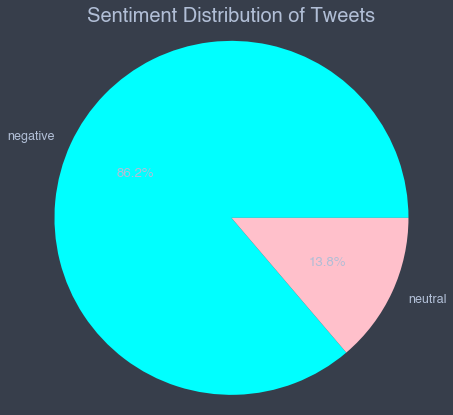

,index,sentiments_val
0,negative,8582
1,neutral,1370


In [33]:
# Plot pie chart of Sentiment Distribution of words
fig = plt.gcf()
fig.set_size_inches(7,7)
colors = ["cyan","pink","yellow"]

pie_df = tweet_sentiments['sentiments_val'].value_counts().reset_index()

plt.pie(pie_df['sentiments_val'],
        labels=pie_df["index"],
        radius=2,
        colors=colors,
        autopct="%1.1f%%")

plt.axis('equal')
plt.title('Sentiment Distribution of Tweets', fontsize=20)
plt.show()
pie_df

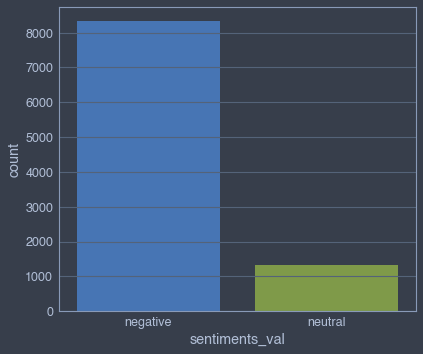

In [35]:
# Inspect keyword sentiment
keywords=['russia']
pattern = '|'.join(keywords)
keyword_sent_df = tweet_sentiments[(tweet_sentiments["tweet"].str.contains(pattern))]
sns.countplot(x=keyword_sent_df["sentiments_val"]);
